[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/MSML_602/blob/main/Project/checkpoint2.ipynb)

# **Installing and Importing Libraries**

In [1]:
!pip install -U pip
!pip install "cleanvision[huggingface]"
!pip install pyod
# !pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 86.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.9.0
    Uninstalling fsspec-2024.9.0:
      Successfully uninstalled fsspec-2024.9.0
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=5cac92347487722a8c0b41941628c8481742a427c99047a42742db64feb9775c
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built py

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, concatenate_datasets
from cleanvision import Imagelab
from PIL import Image
import requests
# from transformers import CLIPProcessor, CLIPModel
import torch
import cv2
from pyod.models.knn import KNN
import imagehash
from sklearn.decomposition import PCA

# **Importing Dataset from Hugging Face**

In [3]:
dataset_dict = load_dataset("zalando-datasets/fashion_mnist")
train_images = np.array(dataset_dict['train']['image'])
train_labels = np.array(dataset_dict['train']['label'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.02k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/30.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/5.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

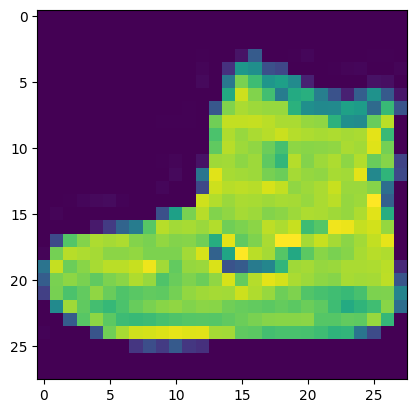

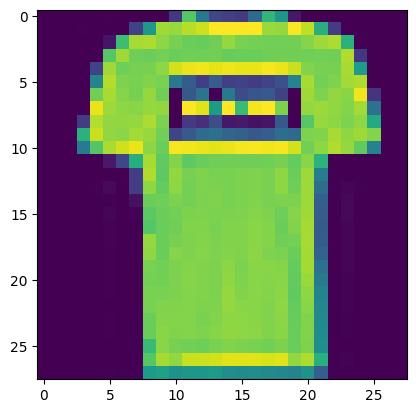

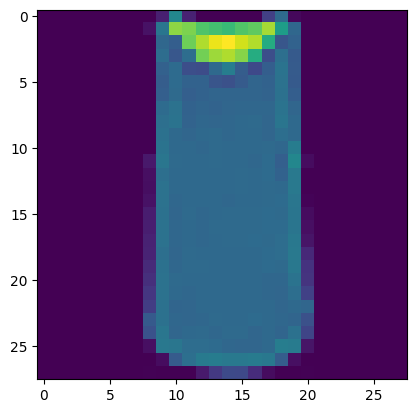

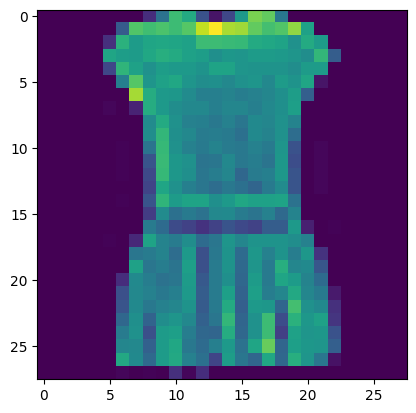

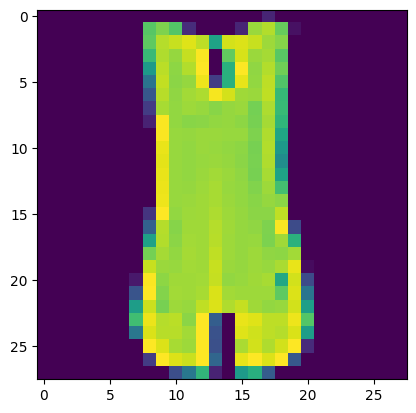

In [4]:
# showing some sample images
for im in range(5):
  plt.imshow(train_images[im])
  plt.show()

# **Data Processing and Cleaning**

Instead of manually creating functions for each type of potential issue in the dataset for example Low Information / Illumination Issue / Blurry Images / ....we will use [IMAGELAB](https://github.com/cleanlab/cleanvision) LIBRARY which does all of this for use at once

In [5]:
imagelab = Imagelab(hf_dataset=dataset_dict['train'], image_key="image")
imagelab.find_issues()

Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

Issue checks completed. 70003 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


In [6]:
imagelab.issue_summary

,issue_type,num_images
0,grayscale,60000
1,low_information,9266
2,near_duplicates,721
3,dark,16
4,light,0
5,blurry,0
6,odd_aspect_ratio,0
7,odd_size,0
8,exact_duplicates,0


In [7]:
# Following dataset helps us to view information about each image, such as what types of issues it exhibits and its quality score with respect to each type of issue.
issue_df = imagelab.issues
issue_df

,odd_size_score,is_odd_size_issue,odd_aspect_ratio_score,is_odd_aspect_ratio_issue,low_information_score,is_low_information_issue,light_score,is_light_issue,grayscale_score,is_grayscale_issue,dark_score,is_dark_issue,blurry_score,is_blurry_issue,exact_duplicates_score,is_exact_duplicates_issue,near_duplicates_score,is_near_duplicates_issue
0,1.0,False,1.0,False,0.471182,False,1.0,False,0,True,0.964706,False,0.782126,False,1.0,False,1.0,False
1,1.0,False,1.0,False,0.488036,False,1.0,False,0,True,0.992824,False,0.609102,False,1.0,False,1.0,False
2,1.0,False,1.0,False,0.307095,False,1.0,False,0,True,0.835373,False,0.759629,False,1.0,False,1.0,False
3,1.0,False,1.0,False,0.412742,False,1.0,False,0,True,0.762118,False,0.793485,False,1.0,False,1.0,False
4,1.0,False,1.0,False,0.326907,False,1.0,False,0,True,1.000000,False,0.830525,False,1.0,False,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,1.0,False,1.0,False,0.273430,True,1.0,False,0,True,0.868078,False,0.830474,False,1.0,False,1.0,False
59996,1.0,False,1.0,False,0.277721,True,1.0,False,0,True,0.996078,False,0.867324,False,1.0,False,1.0,False
59997,1.0,False,1.0,False,0.348192,False,1.0,False,0,True,1.000000,False,0.852952,False,1.0,False,1.0,False
59998,1.0,False,1.0,False,0.436144,False,1.0,False,0,True,0.620275,False,0.507929,False,1.0,False,1.0,False


## Check for Images with Low Information in dataset
There are many ways to check if the image contains low information or not eg using entropy value or using variance across different axes of the image.

In [8]:
images_with_low_information = issue_df[issue_df['is_low_information_issue'] == True].reset_index()[['index','low_information_score']]

In [9]:
images_with_low_information

,index,low_information_score
0,8,0.292135
1,13,0.296907
2,14,0.244999
3,30,0.169186
4,38,0.294015
...,...,...
9261,59951,0.268701
9262,59991,0.267101
9263,59995,0.273430
9264,59996,0.277721


0.0899287558436393


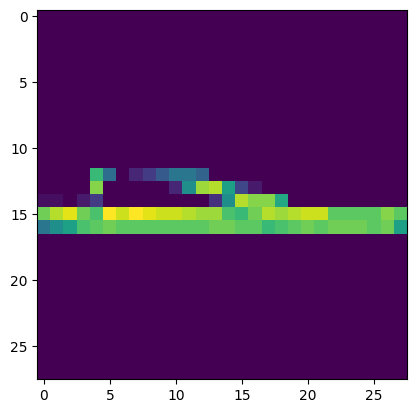

0.11854532484067504


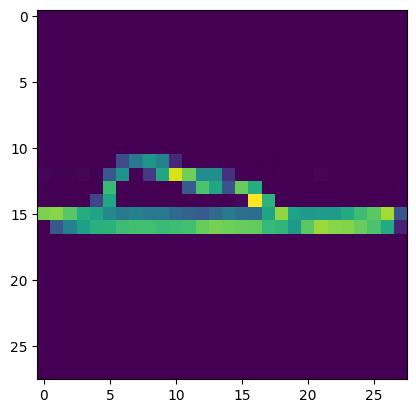

0.11101413243105429


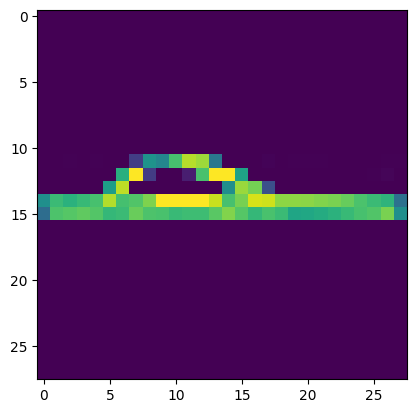

0.1163893504731558


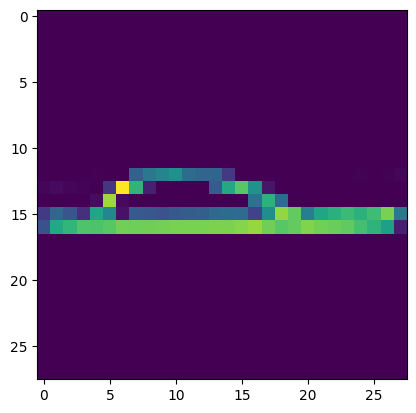

0.10934567159828923


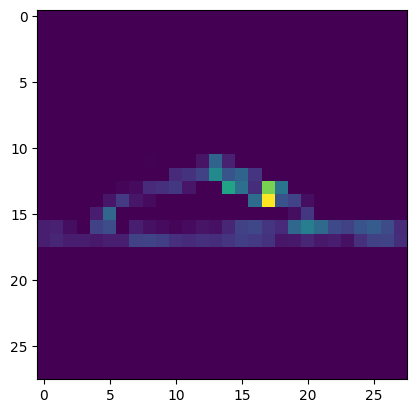

0.11897443116276374


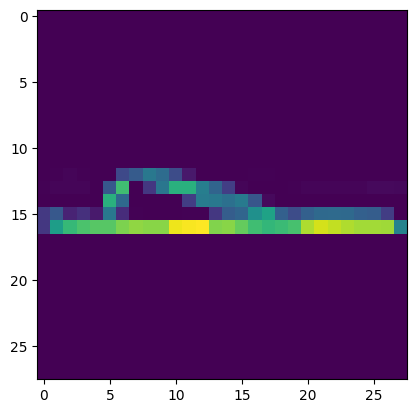

0.10875941991646615


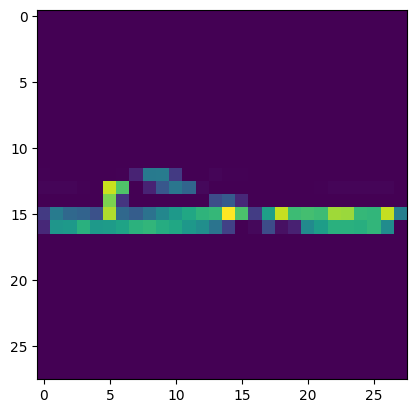

0.11192521316499089


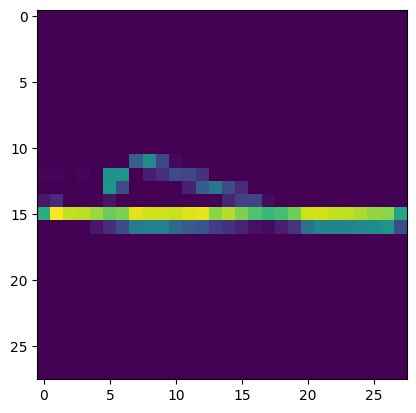

0.11186004243688963


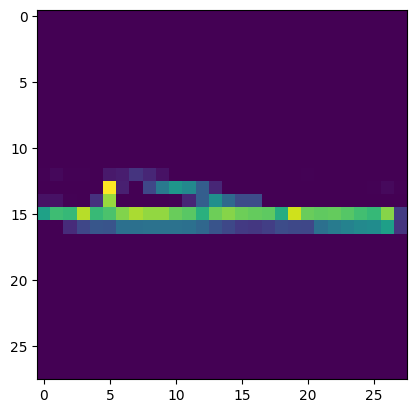

0.1164707011683056


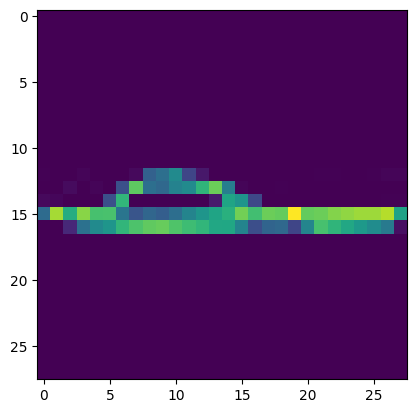

0.11040733886270906


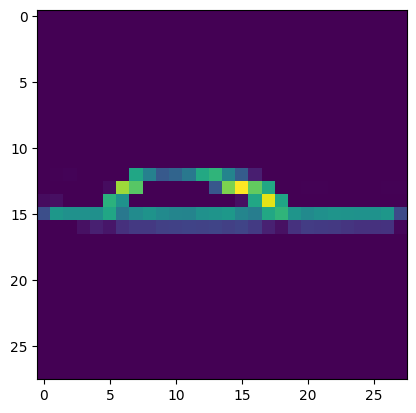

0.11625270131375705


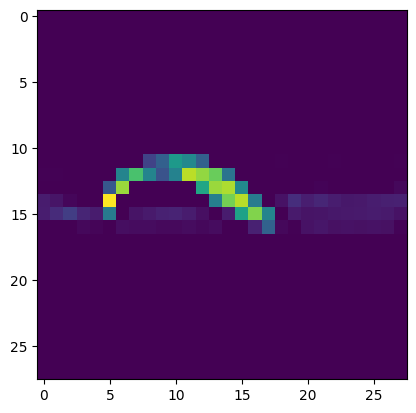

0.11109588249451337


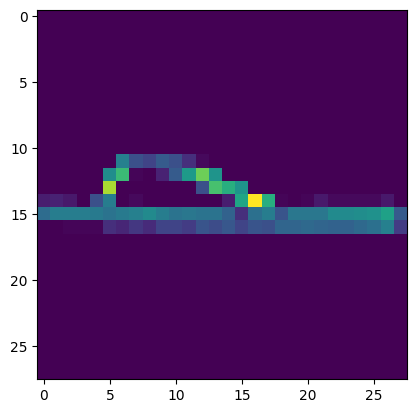

0.11771250277269284


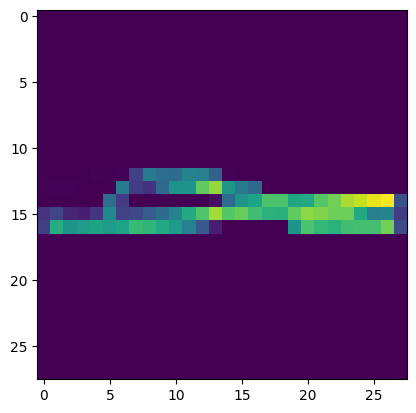

0.09260060769381392


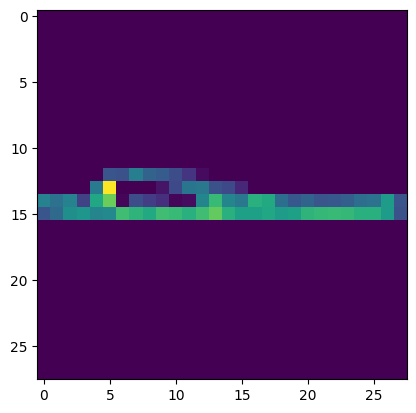

0.11698095462301046


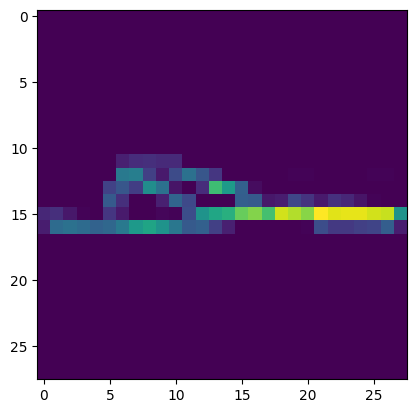

0.0679754028789433


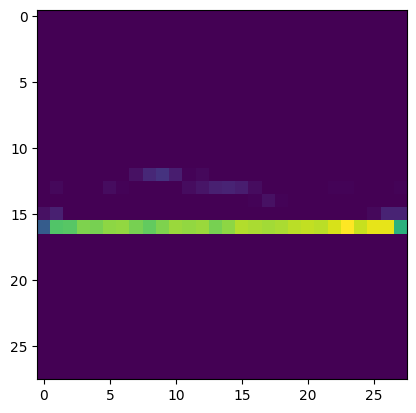

0.10871081749139307


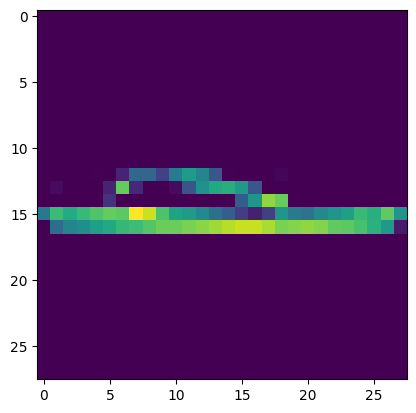

0.11589830084100633


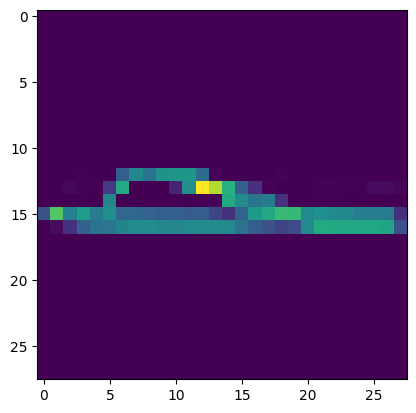

0.1178638505264932


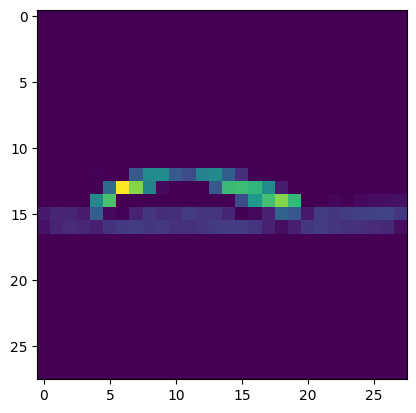

0.11850405429912536


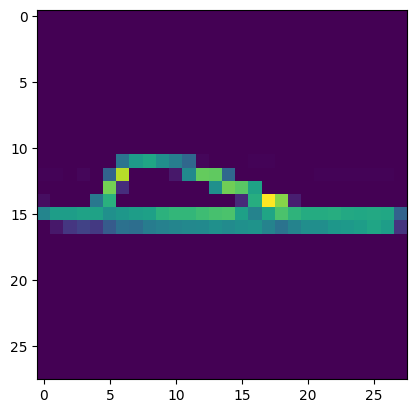

0.11990548566545312


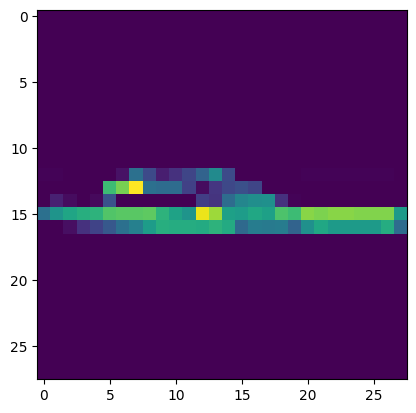

0.10774408797585569


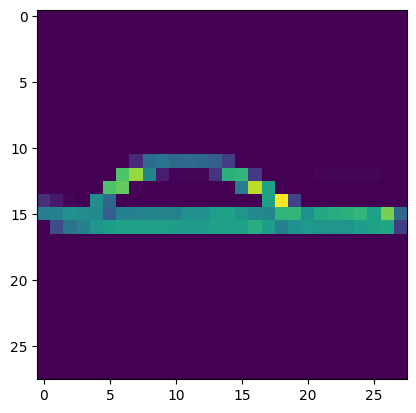

0.11306463117649751


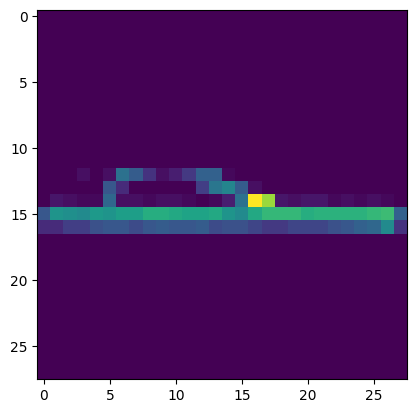

0.11354947005140958


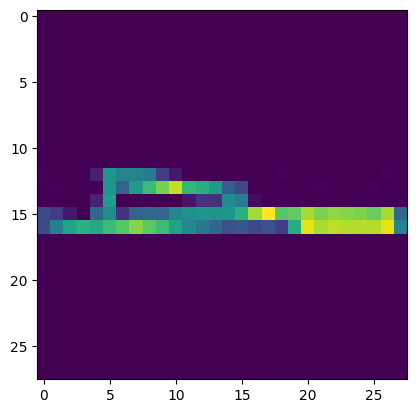

0.11170031143844045


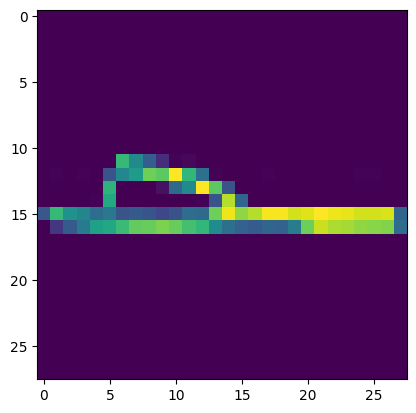

0.11739680256685286


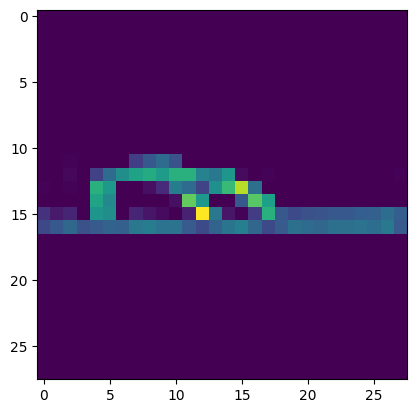

0.10851604198761683


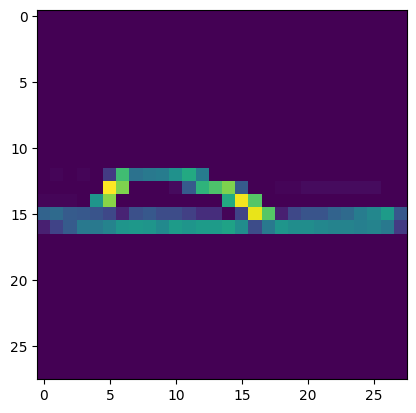

0.10961169433042


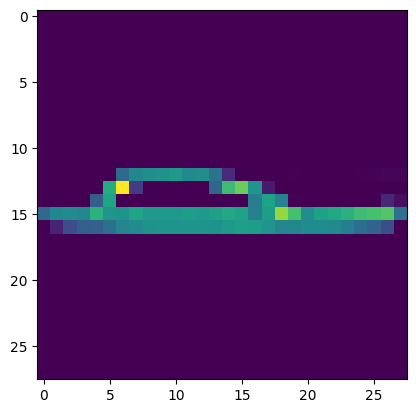

0.1155371859471197


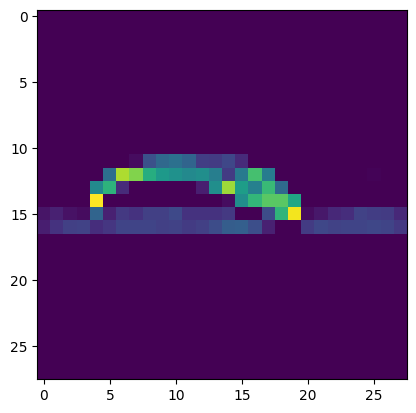

In [10]:
# seeing some sample images with low information
for score, i in zip(images_with_low_information['low_information_score'], images_with_low_information['index']):
  if score < 0.12:
    plt.imshow(train_images[i])
    print(score)
    plt.show()

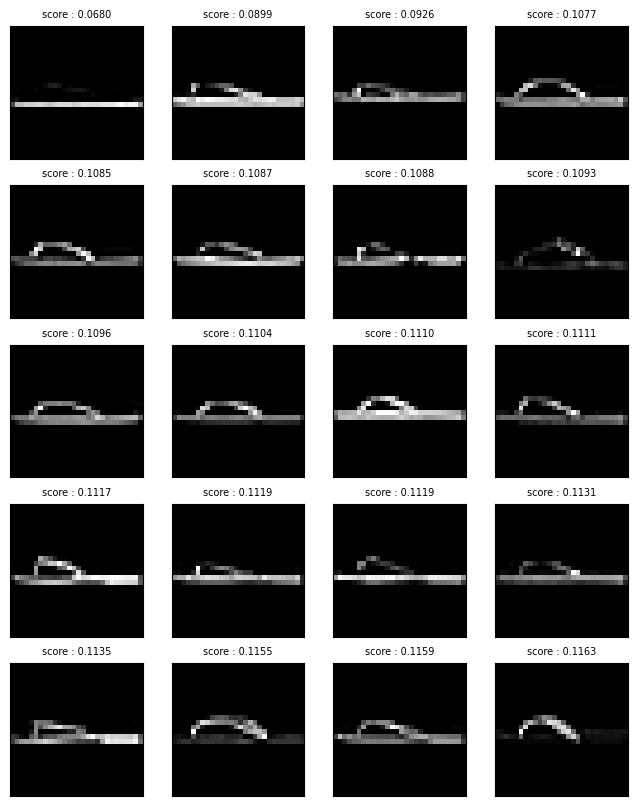

In [11]:
imagelab.visualize(issue_types=["low_information"], num_images=20)

In [12]:
img_index_with_low_information = images_with_low_information['index']

In [13]:
'''
Following is a way to manually calculate entropy value of an image to check for low information issue.
This method suggests that there are no images with low information in our dataset.
I am not sure what method does the Imagelab library use to check for low information issue.
'''

# def calculate_entropy(image):
#     histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
#     histogram = histogram / np.sum(histogram)
#     entropy = -np.sum(histogram * np.log2(histogram + np.finfo(float).eps))
#     return entropy

# entropies = [calculate_entropy(image) for image in train_images]
# threshold = 0.5  # Adjust this threshold as needed
# low_entropy_images = [image for image, entropy in zip(train_images, entropies) if entropy < threshold]

# for image in low_entropy_images:
#     plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#     plt.show()

'\nFollowing is a way to manually calculate entropy value of an image to check for low information issue.\nThis method suggests that there are no images with low information in our dataset.\nI am not sure what method does the Imagelab library use to check for low information issue.\n'

## Check for Blurry Images in dataset
There are many ways to check blurriness in an image like laplacian and fourier transform.

Imagelab library suggests that are are no blurry images in our dataset, let's check that manually too by implementing our own version to check for blurry images.

In [14]:
is_blurry_image = [cv2.Laplacian(image, cv2.CV_64F).var()<1000 for image in train_images]

In [15]:
for i in is_blurry_image:
  if i == True:
    print(i)

Hence this shows that there are no blurry images in our dataset

## Check for Light / Dark Images in dataset
Here we first identify if there are too dark or too light images in our dataset


In [16]:
dark_images = issue_df[issue_df['is_dark_issue'] == True].reset_index()[['index','dark_score']]

In [17]:
dark_images

,index,dark_score
0,1820,0.307216
1,2195,0.217686
2,7865,0.307882
3,11870,0.213098
4,13690,0.309961
5,16835,0.269333
6,17738,0.313216
7,18047,0.308549
8,24370,0.230118
9,27292,0.270588


0.3072156862745095


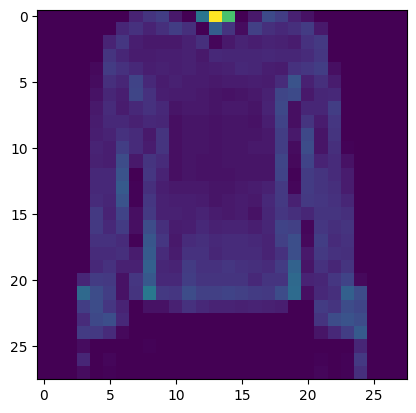

0.21768627450980343


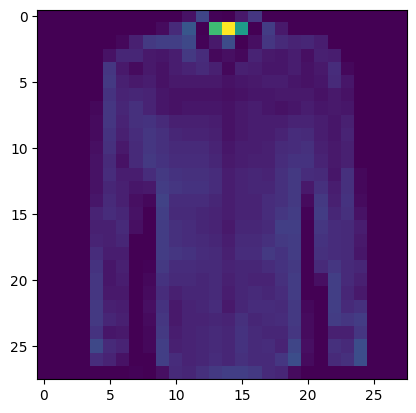

0.307882352941176


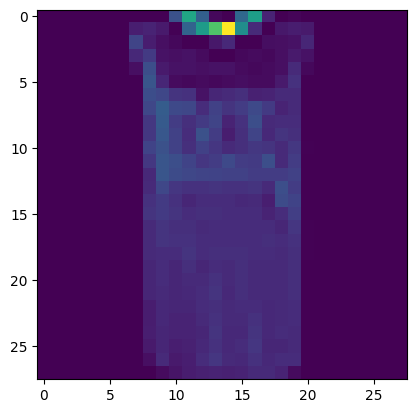

0.21309803921568596


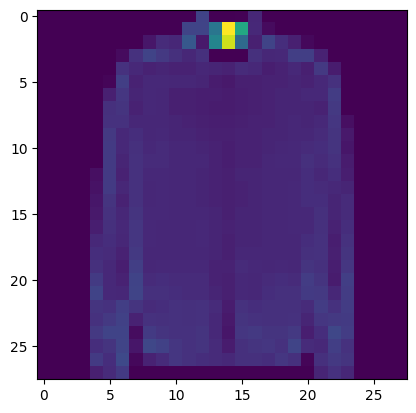

0.30996078431372354


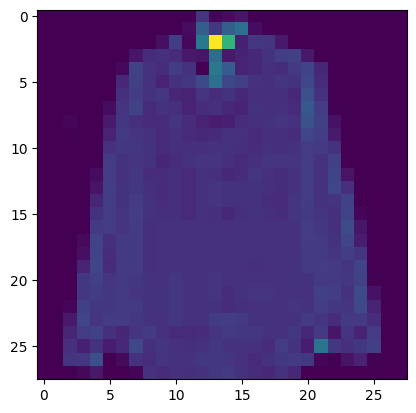

0.2693333333333327


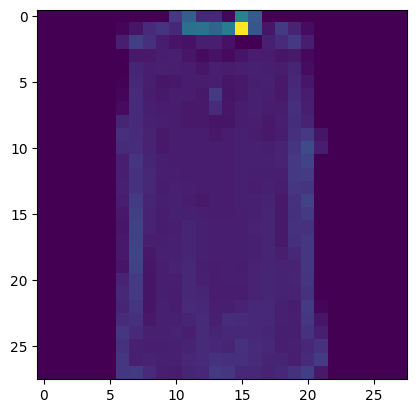

0.3132156862745081


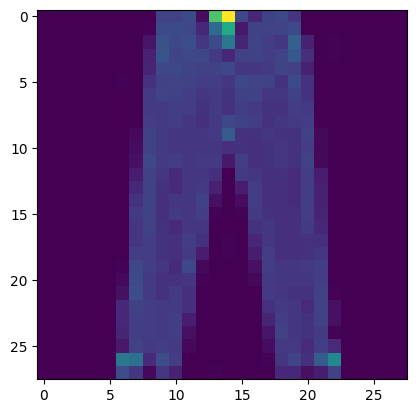

0.30854901960784253


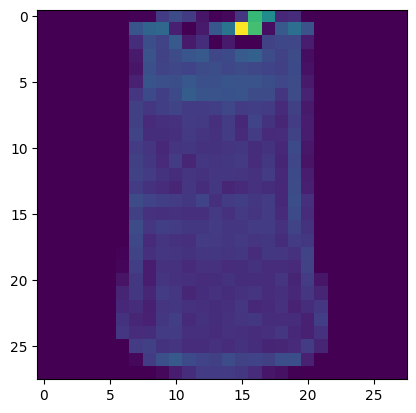

0.23011764705882287


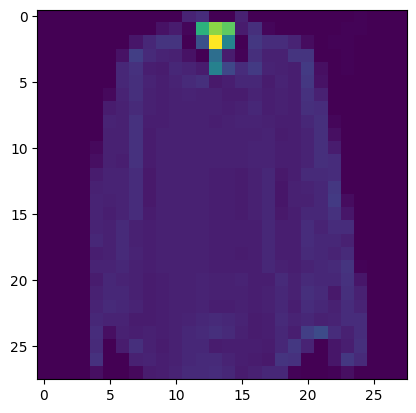

0.27058823529411763


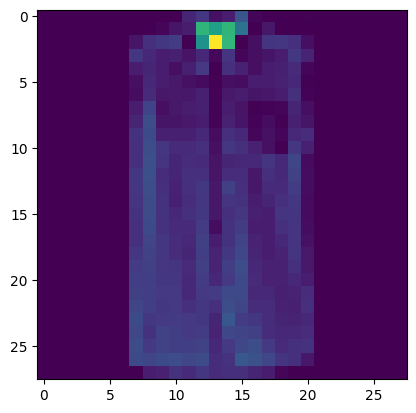

0.2045882352941175


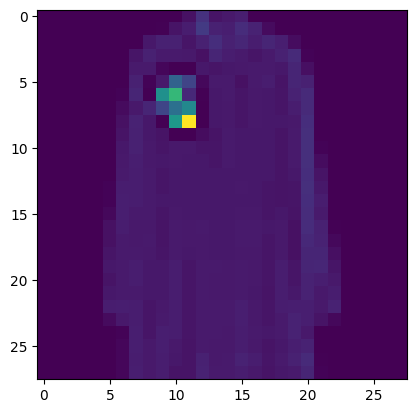

0.30596078431372453


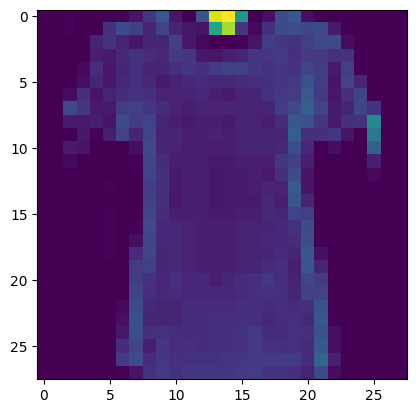

0.2896078431372541


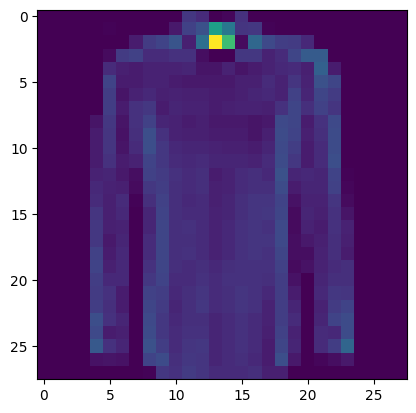

0.20392156862745098


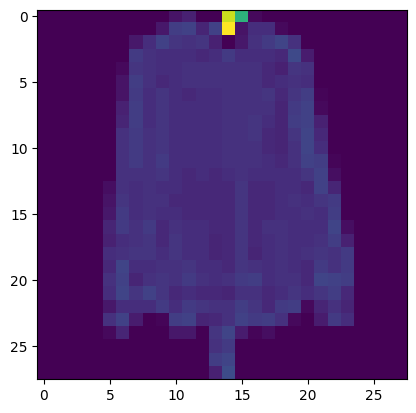

0.25623529411764673


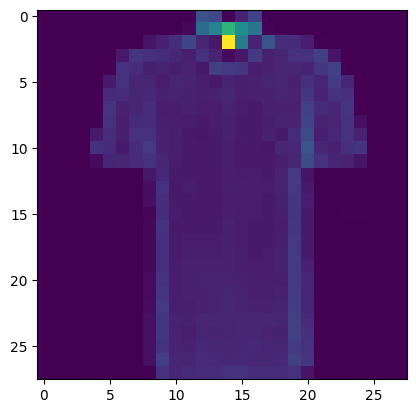

0.2836862745098036


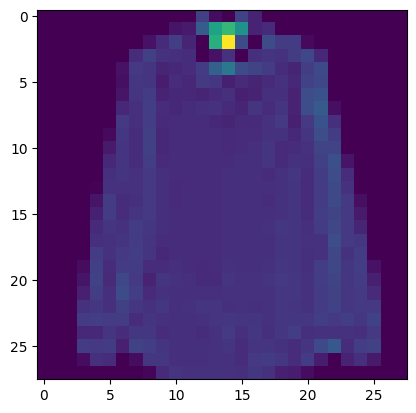

In [18]:
# seeing some sample images with low information
for score, i in zip(dark_images['dark_score'], dark_images['index']):
  plt.imshow(train_images[i])
  print(score)
  plt.show()

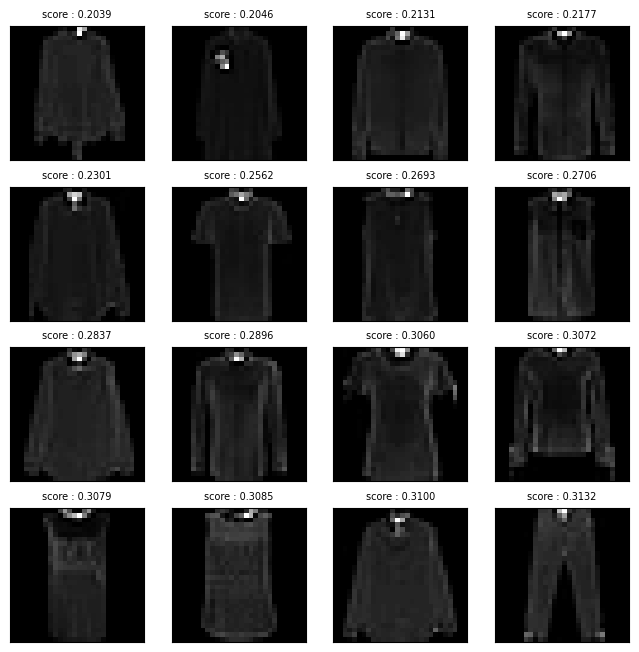

In [19]:
imagelab.visualize(issue_types=["dark"], num_images=20)

In [20]:
dark_img_index = dark_images['index']

## Check for duplicate Images
To manually implement this you will have to convert the images into embeddings and then using a similarity measure you can check if the images are similiar or not. If the similarity is too high means they are near duplicates.

In [21]:
duplicate_images = issue_df[issue_df['is_near_duplicates_issue'] == True].reset_index()[['index','near_duplicates_score']]

In [22]:
duplicate_images

,index,near_duplicates_score
0,189,0.500000
1,264,0.500000
2,337,0.333333
3,360,0.500000
4,562,0.500000
...,...,...
716,59456,0.500000
717,59653,0.500000
718,59690,0.333333
719,59812,0.500000


Set: 0


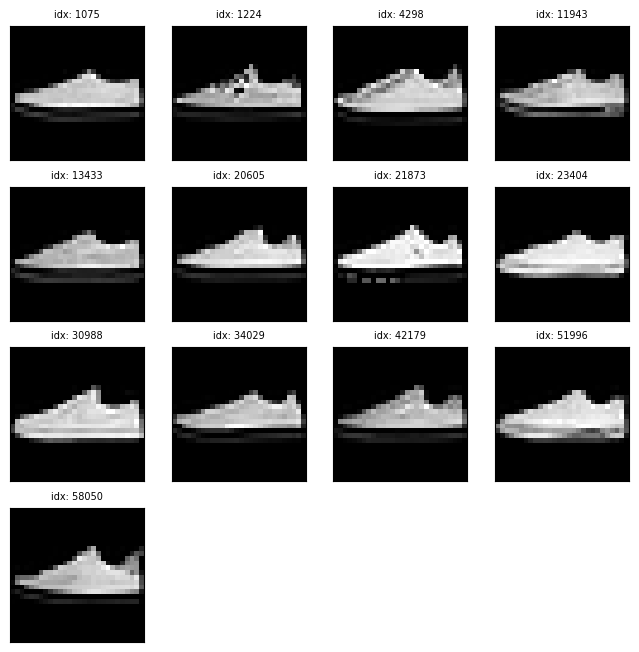

Set: 1


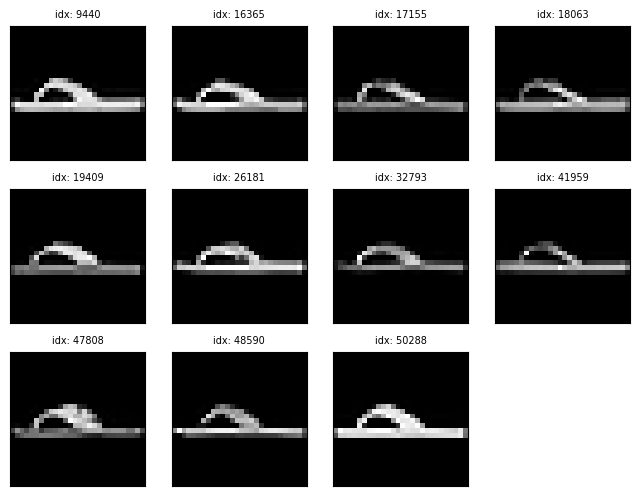

Set: 2


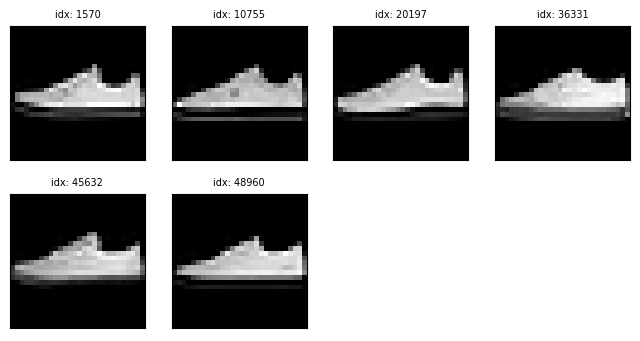

Set: 3


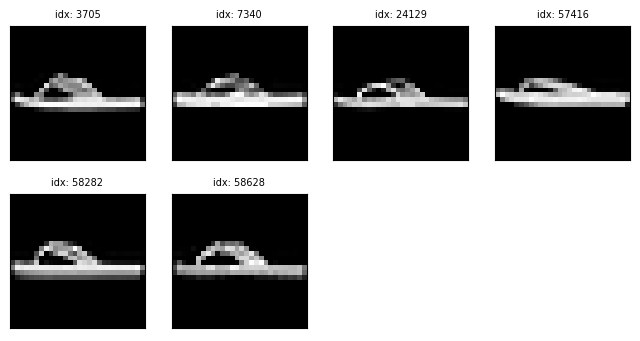

Set: 4


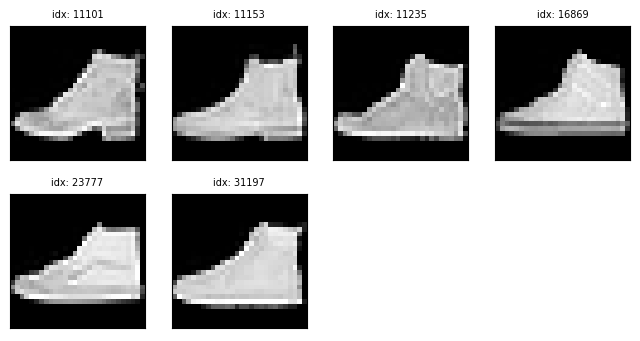

In [23]:
# visualizing 5 near duplicate sets
imagelab.visualize(issue_types=["near_duplicates"], num_images=5)

In [24]:
print(f'Total #Duplicate Sets Found : {len(imagelab.info["near_duplicates"]["sets"])}')

Total #Duplicate Sets Found : 314


In [25]:
duplicate_images_index = []
for i in imagelab.info["near_duplicates"]["sets"]:
  for j,counter in zip(i,range(0,len(i))):
    if counter == 0:
      continue
    else:
      duplicate_images_index.append(j)

## Removing Issue Based Images from the Dataset

In [26]:
img_index_to_remove = list(set(list(img_index_with_low_information) + list(dark_img_index) + list(duplicate_images_index)))

In [27]:
reduced_train_images = []
reduced_train_labels = []

In [28]:
for counter, im, label in zip(range(len(train_images)), train_images, train_labels):
  if counter in img_index_to_remove:
    continue
  else:
    reduced_train_images.append(im)
    reduced_train_labels.append(label)

# **Image Resizing / Transformations**
Here we check if all the images are of same shape and size, else we perform some transformations / reshaping

In [29]:
size_list = [reduced_train_images[i].shape for i in range(len(reduced_train_images))]
print(set(size_list))

{(28, 28)}


Hence this shows that all the images in our dataset are of size 28*28 hence we dont need to do any reshaping

# **Normalize Data**
Here we normalize our pixel values in dataset from 0-255 to 0-1


In [30]:
reduced_train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0, 155, 236, 207, 178, 107, 156, 161, 109,  64,  23,  77, 130,
         72,  15],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
         69, 207, 223, 218, 216, 216, 163, 127, 121, 122, 146, 141,  88,
        172,  66],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   1,   0,
        200, 232, 232, 233, 229, 223, 223, 215, 213, 164, 127, 123, 196,
        229,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        183, 225, 216, 223, 228, 235, 227, 224, 222, 224, 221, 223, 245,
        173,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        193, 228, 218, 213, 198, 180, 212, 210, 211, 213, 223, 220, 243,
        202,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   3,   0,  12,
        219, 220, 212, 218, 192, 169, 227, 208, 218, 224, 212, 226, 197,
        209,  52],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,   0,  99,
        244, 222, 220, 218, 203, 198, 221, 215, 213, 222, 220, 245, 119,
        167,  56],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   4,   0,   0,  55,
        236, 228, 230, 228, 240, 232, 213, 218, 223, 234, 217, 217, 209,
         92,   0],
       [  0,   0,   1,   4,   6,   7,   2,   0,   0,   0,   0,   0, 237,
        226, 217, 223, 222, 219, 222, 221, 216, 223, 229, 215, 218, 255,
         77,   0],
       [  0,   3,   0,   0,   0,   0,   0,   0,   0,  62, 145, 204, 228,
        207, 213, 221, 218, 208, 211, 218, 224, 223, 219, 215, 224, 244,
        159,   0],
       [  0,   0,   0,   0,  18,  44,  82, 107, 189, 228, 220, 222, 217,
        226, 200, 205, 211, 230, 224, 234, 176, 188, 250, 248, 233, 238,
        215,   0],
       [  0,  57, 187, 208, 224, 221, 224, 208, 204, 214, 208, 209, 200,
        159, 245, 193, 206, 223, 255, 255, 221, 234, 221, 211, 220, 232,
        246,   0],
       [  3, 202, 228, 224, 221, 211, 211, 214, 205, 205, 205, 220, 240,
         80, 150, 255, 229, 221, 188, 154, 191, 210, 204, 209, 222, 228,
        225,   0],
       [ 98, 233, 198, 210, 222, 229, 229, 234, 249, 220, 194, 215, 217,
        241,  65,  73, 106, 117, 168, 219, 221, 215, 217, 223, 223, 224,
        229,  29],
       [ 75, 204, 212, 204, 193, 205, 211, 225, 216, 185, 197, 206, 198,
        213, 240, 195, 227, 245, 239, 223, 218, 212, 209, 222, 220, 221,
        230,  67],
       [ 48, 203, 183, 194, 213, 197, 185, 190, 194, 192, 202, 214, 219,
        221, 220, 236, 225, 216, 199, 206, 186, 181, 177, 172, 181, 205,
        206, 115],
       [  0, 122, 219, 193, 179, 171, 183, 196, 204, 210, 213, 207, 211,
        210, 200, 196, 194, 191, 195, 191, 198, 192, 176, 156, 167, 177,
        210,  92],
       [  0,   0,  74, 189, 212, 191, 175, 172, 175, 181, 185, 188, 189,
        188, 193, 198, 204, 209, 210, 210, 211, 188, 188, 194, 192, 216,
        170,   0],
       [  2,   0,   0,   0,  66, 200, 22

In [31]:
def normalize_image_np(image):
    norm_img = (image - np.min(image)) / (np.max(image) - np.min(image))
    return norm_img

In [32]:
normalized_train_images = [normalize_image_np(image) for image in reduced_train_images]

In [33]:
normalized_train_images[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [34]:
normalized_train_images = np.array(normalized_train_images)

# **Data Exploration**

## Create Embeddings using Eigen Value Decomposition (PCA)

In [52]:
# flattening the images
X_train = normalized_train_images.reshape(50503, 28 * 28)
Y_train = reduced_train_labels

In [53]:
# fitting PCA
pca = PCA(n_components = None)
X_new = pca.fit_transform(X_train)

In [54]:
# Calculating new no of features such that 85% of the information in the dataset is retained
threshold = 0.85
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= threshold) + 1
print(n_components)

46


Hence we can say that we have extracted 195 features out of 28*28 features which retains 95% of the information in the dataset

In [55]:
# fitting PCA again to get those 195 features
pca = PCA(n_components = n_components)
X_train = pca.fit_transform(X_train)
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,-2.208439,6.145195,-4.134287,0.815395,-0.687318,-1.570434,0.025577,1.012756,0.656292,0.215190,...,0.116200,-0.037935,0.072052,0.016992,0.112778,-0.542487,-0.337188,0.450976,0.025373,0.296288
1,4.859011,-2.047888,-2.156956,0.937111,1.968101,3.931461,-1.683637,-1.101950,0.847573,0.097526,...,-0.116398,0.046202,-0.093764,-0.378994,-0.125859,0.199978,-0.132966,-0.066531,0.016735,-0.186447
2,-3.259009,-4.971990,0.595483,0.373040,0.331977,-0.572131,0.530642,0.072513,0.473651,0.246415,...,0.569309,0.294184,-0.353557,0.188509,-0.246925,-0.201548,-0.331330,-0.066482,-0.090224,-0.187455
3,-0.318511,-4.400119,0.550357,1.095033,0.448122,0.335890,-0.305261,0.025219,0.442680,2.009224,...,-0.279800,-0.414233,-0.084571,0.215792,-0.283175,-0.194854,-0.277283,0.397176,0.253820,0.061514
4,2.592005,-4.669180,-3.178935,-1.135868,-1.698617,-0.518074,1.712628,0.473259,1.015055,0.100512,...,0.431989,0.360399,-0.109942,0.155513,0.031614,0.103302,0.046732,-0.264479,0.045781,-0.385623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50498,-6.586370,0.447454,0.052691,-1.602056,0.221330,0.116083,-0.715780,-1.499584,0.016413,-0.119027,...,0.129045,-0.509618,0.778261,-0.463077,0.011430,-0.376195,-0.256612,0.082516,0.276708,0.277510
50499,0.208006,-1.967429,1.863021,0.868961,-1.563636,-0.547244,-1.121710,0.551923,-0.928694,0.165407,...,0.304787,0.591432,-0.325304,0.093853,0.054438,0.087310,-0.085039,-0.431965,0.213420,0.327283
50500,0.801886,7.768272,-1.141110,-2.367468,-0.231923,1.700106,2.303612,3.891102,-0.974718,0.215461,...,0.189357,0.258287,0.074399,-0.031048,0.087975,0.235431,0.408168,0.520098,-0.558213,-0.244509
50501,2.882347,-4.559922,-2.236861,-1.986208,-0.471375,-1.050567,0.364239,0.116209,-0.994251,-1.611482,...,-0.169781,-0.100659,0.523275,-0.128593,1.071321,0.007489,0.927778,-0.118338,-0.018247,0.304502


### Visualization

In [56]:
# creating 2d features to plot a diagram
pca = PCA(n_components = 2)
X_new_temp = pca.fit_transform(X_train)

In [57]:
dataset = pd.DataFrame(X_new_temp, columns=['Feature 1', 'Feature 2'])
dataset['Label'] = reduced_train_labels

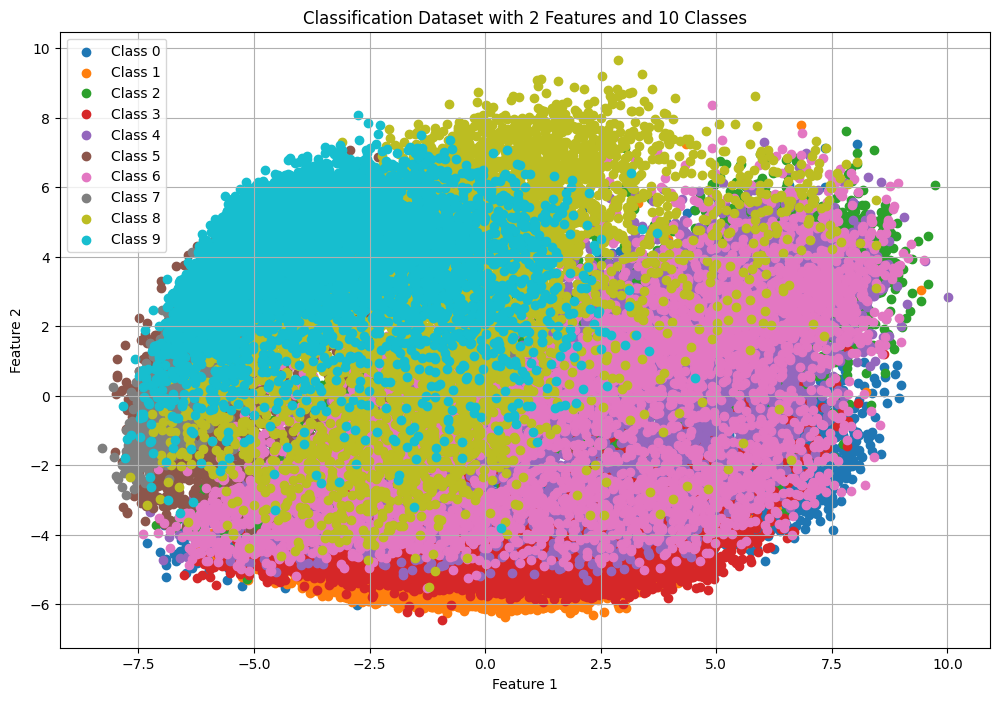

In [58]:
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, 10))  # Use a colormap to get distinct colors for each class

for class_value in range(10):
    subset = dataset[dataset['Label'] == class_value]
    plt.scatter(subset['Feature 1'], subset['Feature 2'], label=f'Class {class_value}', color=colors[class_value])

plt.title('Classification Dataset with 2 Features and 10 Classes')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

## Independent Feature Correlation Analysis
Using this we can decide which feature to drop. If two features are highly correlated then we can drop one of them since they are almost similar features

In [61]:
numerical_features = pd.DataFrame(X_train).select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numerical_features.corr()

# Mask the upper triangle for better readability
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create the heatmap
plt.figure(figsize=(100, 100))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features in Boston Housing Data', fontsize=16)
plt.show()

## Outlier Handling

#### Predicting outliers using Isolation Forest

In [63]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(random_state=42)
clf.fit(X_train)
outlier_pred = clf.predict(X_train)

'''
clf = KNN()
clf.fit(X_new)
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
# y_train_scores = clf.decision_scores_  # raw outlier scores


# outlier_img_index = []
# for i in range(len(y_train_pred)):
#   if y_train_pred[i] == -1:
#     outlier_img_index.append(i)

# X_outliers_removed = []
# Y_outliers_removed = []

# for counter, im, label in zip(range(len(reduced_train_labels)), X_new, reduced_train_labels):

#   if counter in outlier_img_index:
#     continue

#   else:
#     X_outliers_removed.append(im)
#     Y_outliers_removed.append(label)

# #
# labels = dataset['Label']
# labels[outlier_img_index] = 10
# dataset['Label'] = labels
'''

"\nclf = KNN()\nclf.fit(X_new)\ny_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)\n# y_train_scores = clf.decision_scores_  # raw outlier scores\n\n\n# outlier_img_index = []\n# for i in range(len(y_train_pred)):\n#   if y_train_pred[i] == -1:\n#     outlier_img_index.append(i)\n\n# X_outliers_removed = []\n# Y_outliers_removed = []\n\n# for counter, im, label in zip(range(len(reduced_train_labels)), X_new, reduced_train_labels):\n\n#   if counter in outlier_img_index:\n#     continue\n\n#   else:\n#     X_outliers_removed.append(im)\n#     Y_outliers_removed.append(label)\n\n# #\n# labels = dataset['Label']\n# labels[outlier_img_index] = 10\n# dataset['Label'] = labels\n"

#### 2D visualization after removing outliers

In [66]:
dataset['outlier'] = outlier_pred # adding a outlier col in the dataset
dataset['Label'] = dataset['Label'].where(dataset['outlier'] != -1, 10) # creating outlier points as class 10

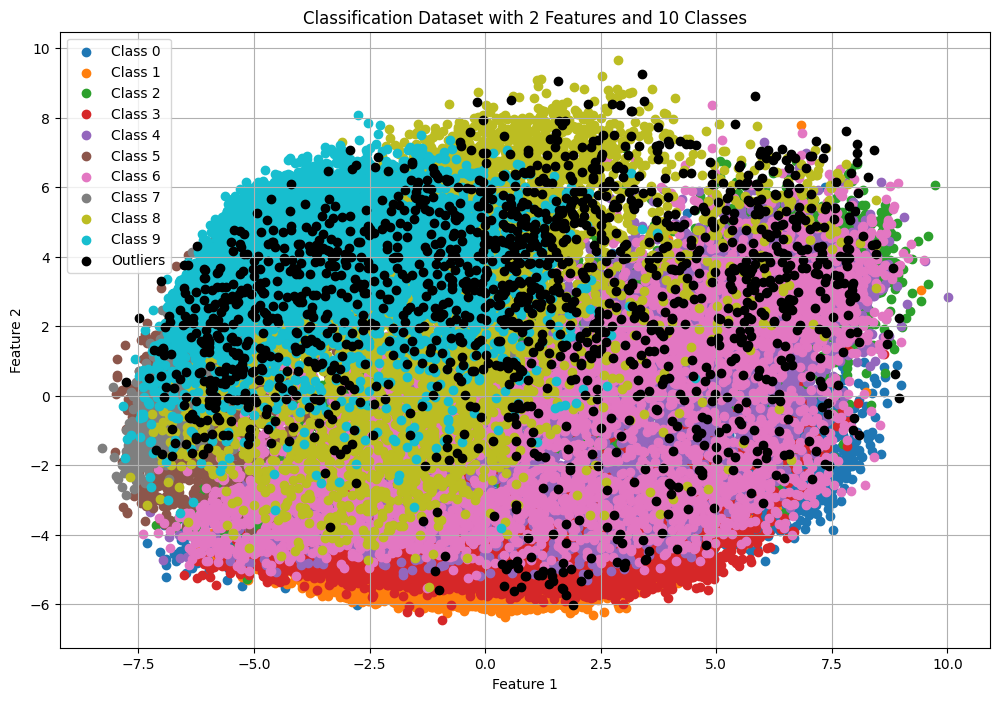

In [67]:
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, 11))  # Use a colormap to get distinct colors for each class

for class_value in range(11):
    subset = dataset[dataset['Label'] == class_value]
    if class_value == 10:
      plt.scatter(subset['Feature 1'], subset['Feature 2'], label=f'Outliers', color='black')
    else:
      plt.scatter(subset['Feature 1'], subset['Feature 2'], label=f'Class {class_value}', color=colors[class_value])

plt.title('Classification Dataset with 2 Features and 10 Classes')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

Note : In 2d plot they might not look at outliers since we have reduced the dimensions but in the original dimensions they are outliers based on isolation forest method

#### Dataset after removal of outliers

In [68]:
train_df = pd.DataFrame(X_train)
train_df['Label'] = Y_train
train_df['outlier'] = outlier_pred

In [69]:
train_df = train_df[train_df['outlier'] != -1]

In [70]:
X_train = np.array(train_df.drop(['Label', 'outlier'], axis=1))
Y_train = np.array(train_df['Label'])